In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import pydicom
from tqdm import tqdm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import kornia
import kornia.augmentation as augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import KFold
from skmultilearn.model_selection import iterative_train_test_split
import sys
from torch.cuda import amp
from collections import OrderedDict


In [2]:
sys.path.append('/kaggle/working/notebook/03_experiments')
from script import warmup_scheduler, metrics, helper, resnet


In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'rsna-2023-abdominal-trauma-detection'
    input_dir_path = '/kaggle/input/'
    dataset_path = "/kaggle/dataset/train/"

    volume_path = os.path.join(dataset_path, "volume_256")
    label_path = os.path.join(dataset_path, "train.csv")
    meta_path = os.path.join(dataset_path, "train_series_meta.csv")

    exp_name = "baseline"

    # ============== model cfg =============
    model_arch = "resnet"
    model_depth = 18
    in_chans = 1
    pretrained_path = "/kaggle/input/3D-ResNets-PyTorch/r3d18_K_200ep.pth"

    # ============== training cfg =============
    train_batch_size = 2
    valid_batch_size = train_batch_size
    batch_accum_iter = 32

    epochs = 30
    lr = 1e-4

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
    ]

    valid_aug_list = [
    ]
    
helper.set_seed(CFG.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [25]:
df_label = pd.read_csv(CFG.label_path)
df_meta = pd.read_csv(CFG.meta_path)
df_meta["npy_fname"] = df_meta["patient_id"].astype("str")+"_"+df_meta["series_id"].astype("str")+".npy"
df = pd.merge(df_meta, df_label)

df["bowel_weight"] = df["bowel_healthy"]*1+df["bowel_injury"]*2
df["extravasation_weight"] = df["extravasation_healthy"]*1+df["extravasation_injury"]*6
df["kidney_weight"] = df["kidney_healthy"]*1+df["kidney_low"]*2+df["kidney_high"]*4
df["liver_weight"] = df["liver_healthy"]*1+df["liver_low"]*2+df["liver_high"]*4
df["spleen_weight"] = df["spleen_healthy"]*1+df["spleen_low"]*2+df["spleen_high"]*4
df["any_injury_weight"] = 1+df["any_injury"]*5

sub_columns = ['patient_id', 'series_id',
               'bowel_healthy', 'bowel_injury',
               'extravasation_healthy', 'extravasation_injury',
               'kidney_healthy', 'kidney_low', 'kidney_high',
               'liver_healthy', 'liver_low', 'liver_high',
               'spleen_healthy', 'spleen_low', 'spleen_high'
               ]

bowel_weight = df["bowel_healthy"].sum()/df["bowel_injury"].sum()/2
extra_weight = df["extravasation_healthy"].sum()/df["extravasation_injury"].sum()/2
kidney_weight = (len(df)/df["kidney_healthy"].sum(), len(df)/df["kidney_low"].sum()/2, len(df)/df["kidney_high"].sum()/4)
liver_weight = (len(df)/df["liver_healthy"].sum(), len(df)/df["liver_low"].sum()/2, len(df)/df["liver_high"].sum()/4)
spleen_weight = (len(df)/df["spleen_healthy"].sum(), len(df)/df["spleen_low"].sum()/2, len(df)/df["spleen_high"].sum()/4)
print(bowel_weight)
print(extra_weight)
print(kidney_weight)
print(liver_weight)
print(spleen_weight)

display(df.head())
if CFG.debug:
    df = df[:100]


22.14903846153846
2.4505555555555554
(1.0643922277451423, 13.383522727272727, 10.805045871559633)
(1.112134088762984, 6.134114583333333, 12.942307692307692)
(1.1308209313490158, 7.454113924050633, 5.143013100436681)


,patient_id,series_id,aortic_hu,incomplete_organ,scan_type,npy_fname,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,...,spleen_healthy,spleen_low,spleen_high,any_injury,bowel_weight,extravasation_weight,kidney_weight,liver_weight,spleen_weight,any_injury_weight
0,19,14374,174.0,0,single,19_14374.npy,1,0,1,0,...,1,0,0,0,1,1,1,1,1,1
1,26,18881,255.0,0,arterial,26_18881.npy,1,0,1,0,...,1,0,0,0,1,1,1,1,1,1
2,26,41997,101.0,0,venous,26_41997.npy,1,0,1,0,...,1,0,0,0,1,1,1,1,1,1
3,33,55570,105.0,0,single,33_55570.npy,0,1,0,1,...,1,0,0,1,2,6,1,2,1,6
4,43,24055,127.0,0,arterial,43_24055.npy,0,1,0,1,...,1,0,0,1,2,6,1,1,1,6


In [26]:
# df=df[~df["patient_id"].isin([386,3785,24270,46085,46202,52862])]
df=df[df["scan_type"]!="arterial"].reset_index(drop=True)

In [27]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

X = df

y = df[["bowel_healthy", "bowel_injury", "extravasation_healthy", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high", "liver_healthy", "liver_low", 
        "liver_high", "spleen_healthy", "spleen_low", "spleen_high", "any_injury"]]
for train_index, test_index in mskf.split(X, y):
    df_train=df.iloc[train_index].reset_index(drop=True)
    df_valid=df.iloc[test_index].reset_index(drop=True)
    break

In [28]:
class RSNADataset(Dataset):
    def __init__(self, df, volume_path, transform):
        super().__init__()

        self.df = df
        self.transform = A.Compose(transform)
        self.volume_dir = volume_path
        self.targets = ["bowel_healthy", "bowel_injury",
                        "extravasation_healthy", "extravasation_injury",
                        "kidney_healthy", "kidney_low", "kidney_high",
                        "liver_healthy", "liver_low", "liver_high",
                        "spleen_healthy", "spleen_low", "spleen_high",
                        "any_injury"
                        ]

    def __getitem__(self, index):
        npy_fname = self.df.iloc[index]['npy_fname']
        vol = np.load(os.path.join(self.volume_dir, npy_fname))
        vol = self.transform(image=vol)["image"]
        vol = torch.tensor(vol).float().unsqueeze(dim=0)

        patient_id = self.df.iloc[index]['patient_id']
        series_id = self.df.iloc[index]['series_id']

        labels = self.df.iloc[index][self.targets]
        bowel = torch.tensor(labels["bowel_injury"], dtype=torch.float32).unsqueeze(dim=0)
        extra = torch.tensor(labels["extravasation_injury"], dtype=torch.float32).unsqueeze(dim=0)
        kidney = torch.tensor(labels[4:7].values.astype("int"), dtype=torch.float32)
        liver = torch.tensor(labels[7:10].values.astype("int"), dtype=torch.float32)
        spleen = torch.tensor(labels[10:13].values.astype("int"), dtype=torch.float32)

        return vol, patient_id, series_id, bowel, extra, kidney, liver, spleen

    def __len__(self):
        return len(self.df)


In [29]:
dataset_train = RSNADataset(df_train, CFG.volume_path, CFG.train_aug_list)
dataset_valid = RSNADataset(df_valid, CFG.volume_path, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size, shuffle=True, num_workers=CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.train_batch_size, shuffle=False, num_workers=CFG.num_workers)



len(dataset_train) = 2522
train_image_shape  : torch.Size([1, 256, 256, 256])
train_image_dtype  : torch.float32
train_patient_id   : 43
train_series_id    : 36714
train_label_bowel  : tensor([1.])
train_label_extra  : tensor([1.])
train_label_kidney : tensor([1., 0., 0.])
train_label_liver  : tensor([1., 0., 0.])
train_label_spleen : tensor([1., 0., 0.])

len(dataset_valid) = 631
valid_image_shape  : torch.Size([1, 256, 256, 256])
valid_image_dtype  : torch.float32
valid_patient_id   : 19
valid_series_id    : 14374
valid_label_bowel  : tensor([0.])
valid_label_extra  : tensor([0.])
valid_label_kidney : tensor([1., 0., 0.])
valid_label_liver  : tensor([1., 0., 0.])
valid_label_spleen : tensor([1., 0., 0.])



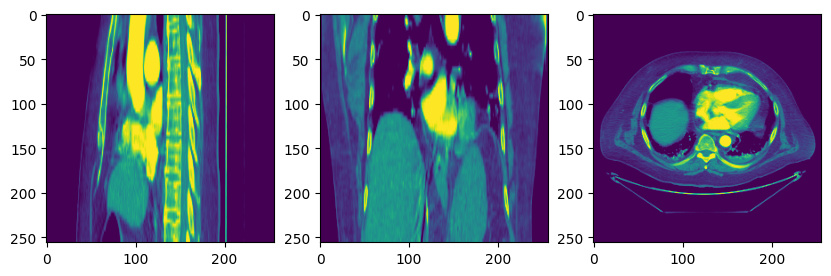

In [30]:
vol = dataset_train[0][0]
c,z,y,x=vol.shape
fig,ax=plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(vol[0,:,:,x//2])
ax[1].imshow(vol[0,:,y//2,:])
ax[2].imshow(vol[0,z//2,:,:])

print(f"""
{len(dataset_train) = }
train_image_shape  : {dataset_train[0][0].shape}
train_image_dtype  : {dataset_train[0][0].dtype}
train_patient_id   : {dataset_train[0][1]}
train_series_id    : {dataset_train[0][2]}
train_label_bowel  : {dataset_train[0][3]}
train_label_extra  : {dataset_train[0][4]}
train_label_kidney : {dataset_train[0][5]}
train_label_liver  : {dataset_train[0][6]}
train_label_spleen : {dataset_train[0][7]}

{len(dataset_valid) = }
valid_image_shape  : {dataset_valid[0][0].shape}
valid_image_dtype  : {dataset_valid[0][0].dtype}
valid_patient_id   : {dataset_valid[0][1]}
valid_series_id    : {dataset_valid[0][2]}
valid_label_bowel  : {dataset_valid[0][3]}
valid_label_extra  : {dataset_valid[0][4]}
valid_label_kidney : {dataset_valid[0][5]}
valid_label_liver  : {dataset_valid[0][6]}
valid_label_spleen : {dataset_valid[0][7]}
""")


# Train

In [31]:
def calc_loss(preds, trues):
    loss_bowel = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(bowel_weight).to(device))
    loss_extra = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(extra_weight).to(device))
    loss_kidney = torch.nn.CrossEntropyLoss(weight=torch.tensor(kidney_weight).to(device))
    loss_liver = torch.nn.CrossEntropyLoss(weight=torch.tensor(liver_weight).to(device))
    loss_spleen = torch.nn.CrossEntropyLoss(weight=torch.tensor(spleen_weight).to(device))
    # loss_bowel = torch.nn.BCEWithLogitsLoss()
    # loss_extra = torch.nn.BCEWithLogitsLoss()
    # loss_kidney = torch.nn.CrossEntropyLoss()
    # loss_liver = torch.nn.CrossEntropyLoss()
    # loss_spleen = torch.nn.CrossEntropyLoss()

    loss_bowel = loss_bowel(preds["p_bowel"], trues["t_bowel"])
    loss_extra = loss_extra(preds["p_extra"], trues["t_extra"])
    loss_kidney = loss_kidney(preds["p_kidney"], trues["t_kidney"])
    loss_liver = loss_liver(preds["p_liver"], trues["t_liver"])
    loss_spleen = loss_spleen(preds["p_spleen"], trues["t_spleen"])
    return loss_bowel+loss_extra+loss_kidney+loss_liver+loss_spleen


In [32]:
def predict(df_predict, series_id, preds):
    p_bowel = torch.sigmoid(preds["p_bowel"]).cpu()
    p_extra = torch.sigmoid(preds["p_extra"]).cpu()
    p_kidney = torch.softmax(preds["p_kidney"], dim=1).cpu()
    p_liver = torch.softmax(preds["p_liver"], dim=1).cpu()
    p_spleen = torch.softmax(preds["p_spleen"], dim=1).cpu()

    df_predict.loc[df_predict["series_id"].isin(series_id.tolist()), "bowel_injury"] = np.array(p_bowel[:, 0])
    df_predict.loc[df_predict["series_id"].isin(series_id.tolist()), "bowel_healthy"] = 1-np.array(p_bowel[:, 0])
    df_predict.loc[df_predict["series_id"].isin(series_id.tolist()), "extravasation_injury"] = np.array(p_extra[:, 0])
    df_predict.loc[df_predict["series_id"].isin(series_id.tolist()), "extravasation_healthy"] = 1-np.array(p_extra[:, 0])
    df_predict.loc[df_predict["series_id"].isin(series_id.tolist()), ["kidney_healthy", "kidney_low", "kidney_high"]] = np.array(p_kidney)
    df_predict.loc[df_predict["series_id"].isin(series_id.tolist()), ["liver_healthy", "liver_low", "liver_high"]] = np.array(p_liver)
    df_predict.loc[df_predict["series_id"].isin(series_id.tolist()), ["spleen_healthy", "spleen_low", "spleen_high"]] = np.array(p_spleen)
    return df_predict


In [33]:
score=0.6388714964971617

In [34]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

model=resnet.generate_model(CFG.model_depth, n_input_channels=CFG.in_chans)
state_dict=torch.load(CFG.pretrained_path)["state_dict"]
state_dict['conv1.weight'] = state_dict['conv1.weight'].sum(dim=1, keepdim=True)

keys_to_exclude = list(state_dict.keys())[:-2]
state_dict = OrderedDict((key, state_dict[key]) for key in keys_to_exclude)

model.load_state_dict(state_dict, strict=False)
model.to(device);

scaler = amp.GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = warmup_scheduler.get_scheduler(CFG.epochs, optimizer)


# slacknotify = helper.SlackNotify("baseline")

for epoch in range(CFG.epochs):
    model.train()

    loss_train, loss_valid = 0.0, 0.0

    pbar_train = tqdm(dataloader_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    for i, (vols, patient_id, series_id, t_bowel, t_extra, t_kidney, t_liver, t_spleen) in enumerate(pbar_train):
        vols= vols.cuda()
        trues = {"t_bowel": t_bowel, "t_extra": t_extra, "t_kidney": t_kidney, "t_liver": t_liver, "t_spleen": t_spleen}
        trues = {key: value.to(device) for key, value in trues.items()}
        
        optimizer.zero_grad()

        with amp.autocast():
            p_bowel, p_extra, p_kidney, p_liver, p_spleen = model(vols)
            preds = {"p_bowel": p_bowel, "p_extra": p_extra, "p_kidney": p_kidney, "p_liver": p_liver, "p_spleen": p_spleen}
            loss = calc_loss(preds, trues)/CFG.batch_accum_iter
            scaler.scale(loss).backward()
            if i%CFG.batch_accum_iter==0:
                scaler.step(optimizer)
                scaler.update()
            loss_train += loss.detach().item()

        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch:>3}/{CFG.epochs:>3}", gpu_mem, lr,
                                                              f"Loss: {loss_train / (i + 1):7.4f}"))

    scheduler.step()
    model.eval()

    pbar_valid = tqdm(dataloader_valid, bar_format="{l_bar}{bar:10}{r_bar:>3}{bar:-0b}")
    df_predict = df_valid[sub_columns].copy()
    for i, (vols, patient_id, series_id, t_bowel, t_extra, t_kidney, t_liver, t_spleen) in enumerate(pbar_valid):
        vols= vols.cuda()
        trues = {"t_bowel": t_bowel, "t_extra": t_extra, "t_kidney": t_kidney, "t_liver": t_liver, "t_spleen": t_spleen}
        trues = {key: value.to(device) for key, value in trues.items()}

        with torch.no_grad():
            p_bowel, p_extra, p_kidney, p_liver, p_spleen = model(vols)
            preds = {"p_bowel": p_bowel, "p_extra": p_extra, "p_kidney": p_kidney, "p_liver": p_liver, "p_spleen": p_spleen}
            loss = calc_loss(preds, trues)
            loss_valid += loss.item()
        df_predict = predict(df_predict, series_id, preds)
        pbar_valid.set_description(("%10s") % (f"{' '*44}Loss: {loss_valid / (i+1):7.4f}"))
    score_ = metrics.score(df_valid, df_predict)

    if score_ < score:
        score = score_
        print(f"score : {score_:.4f}\tSAVED MODEL\n")
        # slacknotify.send_reply(f"epoch : {epoch}\tscore : {score_:.4f}\tBEST")
        torch.save({'model': model.state_dict(), 'score': score,
                    'model_arch': CFG.model_arch, 'model_depth': CFG.model_depth, 'in_chans': CFG.in_chans, },
                   f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"score : {score_:.4f}\n")
        # slacknotify.send_reply(f"epoch : {epoch}\tscore : {score_:.4f}")
    if epoch >=2:break


Epoch   0/ 30  Mem : 13.7GB  LR : 1.00E-04  Loss:  0.2229: 100%|██████████| 1261/1261 [03:25<00:00,  6.15it/s]
                                            Loss:  7.0570: 100%|██████████| 316/316 [00:30<00:00, 10.35it/s]


score : 0.6949



Epoch   1/ 30  Mem : 13.7GB  LR : 1.00E-03  Loss:  0.2095:  11%|█         | 138/1261 [00:22<03:05,  6.06it/s]


KeyboardInterrupt: 

In [ ]:
df_valid.head()


,patient_id,series_id,aortic_hu,incomplete_organ,scan_type,npy_fname,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,...,spleen_healthy,spleen_low,spleen_high,any_injury,bowel_weight,extravasation_weight,kidney_weight,liver_weight,spleen_weight,any_injury_weight
0,19,14374,174.0,0,single,19_14374.npy,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0,1,1,1,1,1,1
1,26,41997,101.0,0,venous,26_41997.npy,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0,1,1,1,1,1,1
2,33,55570,105.0,0,single,33_55570.npy,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1,2,6,1,2,1,6
3,205,62534,216.0,0,single,205_62534.npy,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0,1,1,1,1,1,1
4,310,34700,119.0,0,single,310_34700.npy,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0,1,1,1,1,1,1


In [35]:
df_predict.head()

,patient_id,series_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,19,14374,0.507107,0.492893,0.751596,0.248404,0.419085,0.334435,0.246480,0.432296,0.417423,0.150281,0.448758,0.284549,0.266693
1,26,41997,0.660446,0.339554,0.825613,0.174387,0.429984,0.314386,0.255629,0.420908,0.409577,0.169515,0.571887,0.217568,0.210545
2,33,55570,0.480652,0.519348,0.733107,0.266893,0.412353,0.352388,0.235259,0.395231,0.459292,0.145477,0.466283,0.280184,0.253532
3,205,62534,0.847017,0.152983,0.867407,0.132593,0.627132,0.191379,0.181489,0.414122,0.295577,0.290301,0.622777,0.182184,0.195039
4,310,34700,0.961812,0.038188,0.925238,0.074762,0.927013,0.041767,0.031220,0.444806,0.222783,0.332411,0.648254,0.122649,0.229097
